# Recreating models with PyMC3

This notebook fits a switching model with StatsModels and then PyMC3

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from datetime import datetime

import warnings

import statsmodels.api as sm

from pathlib import Path

In [2]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [3]:
sm.__version__, pm.__version__, az.__version__

('0.11.1', '3.8', '0.8.3')

## Load and prepare data

In [4]:
path_data = Path(".").absolute().parent / "data"
path_xl = path_data / "ESI_GDP.xlsx"

In [5]:
df = pd.read_excel(path_xl, index_col=[0], engine='openpyxl')
df.index = df.index.to_series().apply(lambda x: datetime.strptime(x, '%YM%m'))
df.dropna().head()

,GGDP,GESI,GESISA,GGDPSA
2006-05-01,110.800000,106.863298,106.816640,109.458524
2006-06-01,109.258365,106.396667,106.327908,109.290571
2006-07-01,109.859167,104.883275,104.541073,109.045494
2006-08-01,108.508595,101.666480,101.486939,109.335025
2006-09-01,107.968031,99.242416,101.525884,107.570909


In [6]:
data = pd.concat(
    [df["GGDP"].rename("ggdp"), df["GESI"].rename("gesi"), df["GESI"].tshift(4).rename("gesi[-4]")],
    axis="columns",
).dropna(axis="rows")
data["c"] = 1
data["t"] = range(len(data))
pd.concat([data.head(), data.tail()])

,ggdp,gesi,gesi[-4],c,t
2006-09-01,107.968031,99.242416,106.863298,1,0
2006-10-01,112.464148,105.045745,106.396667,1,1
2006-11-01,110.597609,102.958847,104.883275,1,2
2006-12-01,108.492818,105.941397,101.666480,1,3
2007-01-01,110.620000,105.439110,99.242416,1,4
2016-09-01,97.892436,103.963085,103.638347,1,120
2016-10-01,98.754294,102.285535,106.462025,1,121
2016-11-01,98.282574,102.560216,103.693651,1,122
2016-12-01,97.474446,106.682404,106.788580,1,123
2017-01-01,99.500001,108.382922,103.963085,1,124


## Split data (into training/validation, endog/exog)

In [7]:
cutoff = '2016-10-01'  # 4 periods at the end
cutoff_idx = np.argmax(data.index == cutoff)

train = data.index[:cutoff_idx]
valid = data.index[cutoff_idx:]

In [8]:
endog = data['ggdp']
exog = data[['c', 't', 'gesi[-4]']]

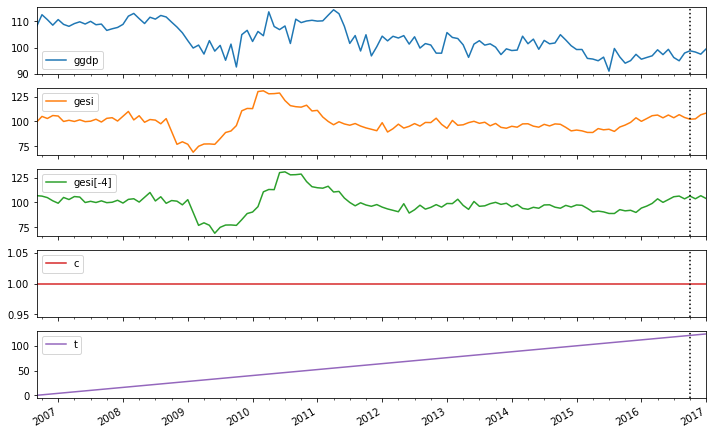

In [9]:
axs = data.plot.line(subplots=True, figsize=(12, 8))
for ax in axs:
    ax.axvline(cutoff, linestyle=':', color='black')

# Fit with `statsmodels`

## Create model

In [10]:
np.random.seed(22)

model_template = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=2, exog=exog, trend=None
)

# Fit model only train data
mdl_sm = None
remaining_tries = 100
with warnings.catch_warnings():
    warnings.simplefilter("error", RuntimeWarning)
    while (mdl_sm is None) and (remaining_tries >= 0):
        try:
            mdl_sm = sm.tsa.MarkovRegression(
                endog=endog.loc[train],
                k_regimes=2,
                exog=exog.loc[train],
                trend=None,
            ).fit(search_reps=2000, em_iter=20, disp=True)
        except RuntimeWarning:
            remaining_tries -= 1

# Get coefficients
coef_sm = pd.DataFrame(
    {
        "value": mdl_sm.params,
        "std": pd.Series(np.sqrt(np.diag(mdl_sm.cov_params())), mdl_sm.params.index),
        "z": mdl_sm.tvalues,
    }
)

Optimization terminated successfully.
         Current function value: 2.418175
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38


## Get dataframe of predictions

In [11]:
# Get dataframe of predictions
pred_ins = pd.Series(
    mdl_sm.predict(),
    index=train,
    name="Conditional Mean (In-sample)",
)
pred_oos = pd.Series(
    model_template.predict(mdl_sm.params, start=cutoff),
    index=valid,
    name="OOS Mean",
)
# Conditional prediction
pred_cond = pd.DataFrame(
    model_template.predict(mdl_sm.params, conditional=True)[:, cutoff_idx:].T,
    index=valid,
    columns=["OOS (Regime 0)", "OOS (Regime 1)"],
)
pred_all = pd.concat([pred_ins, pred_oos], axis="rows")

# Bunch together
df_sm = pd.DataFrame(
    {
        "actual": endog,
        "pred": pred_all,
        "resid": endog - pred_all,
        "prob_raw": pd.Series(
            mdl_sm.predicted_marginal_probabilities[0], index=train
        ),
        "prob_filtered": mdl_sm.filtered_marginal_probabilities[0],
        "prob_smoothed": mdl_sm.smoothed_marginal_probabilities[0],
    }
)

## Overview

In [12]:
coef_sm

,value,std,z
p[0->0],0.900406,0.054026,16.666120
p[1->0],0.175875,0.077135,2.280086
c[0],91.023413,4.121857,22.083109
c[1],73.668905,4.698348,15.679747
t[0],-0.103927,0.009000,-11.547844
t[1],-0.071077,0.017072,-4.163492
gesi[-4][0],0.177627,0.037707,4.710701
gesi[-4][1],0.366106,0.046179,7.928044
sigma2,5.509277,0.901180,6.113402


In [13]:
df_sm

,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.968031,110.297024,-2.328994,0.638458,0.909223,0.895302
2006-10-01,112.464148,110.357952,2.106196,0.834636,0.727948,0.802506
2006-11-01,110.597609,109.912499,0.685110,0.703296,0.711477,0.811726
2006-12-01,108.492818,109.084496,-0.591678,0.691362,0.774210,0.835188
2007-01-01,110.620000,108.487531,2.132469,0.736815,0.642783,0.830177
...,...,...,...,...,...,...
2016-09-01,97.892436,97.024140,0.868297,0.900340,0.989715,0.989715
2016-10-01,98.754294,97.375893,1.378401,NaN,NaN,NaN
2016-11-01,98.282574,96.789639,1.492934,NaN,NaN,NaN
2016-12-01,97.474446,97.223520,0.250926,NaN,NaN,NaN


# Recreate with PyMC3

## Define transitions class

In [16]:
class MarkovStateTransitions(pm.Categorical):
    """Distribution of Markov state transitions.

    """

    def __init__(self, trans_prob=None, init_prob=None, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)

        self.trans_prob = trans_prob
        self.init_prob = init_prob

        # Housekeeping
        self.mode = tt.cast(0, dtype="int64")
        self.k = 2

    def logp(self, x) -> tt.Tensor:
        """Log likelihood of chain `x`."""
        
        trans_prob = self.trans_prob

        p = trans_prob[x[:-1]]  # probability of transitioning based on previous state
        x_i = x[1:]  # the state you end up in

        init_like = pm.Categorical.dist(p=self.init_prob).logp(x[0])
        chain_like = pm.Categorical.dist(p, shape=(self.shape[0], 2)).logp_sum(x_i)

        return init_like + chain_like
    
    # TODO: random() to allow sampling chains

## Create model

In [19]:
warnings.simplefilter("ignore", FutureWarning)

In [61]:
import pymc3.distributions.transforms as tr

In [84]:
L = 2
T = len(train)

with pm.Model() as m:
    pm.Data("t", exog["t"].loc[train])
    pm.Data("gesi[-4]", exog["gesi[-4]"].loc[train])
    pm.Data("ggdp", endog.loc[train])

    #
    pm.Normal(
        "c",
        mu=endog.mean(),
        sigma=endog.mean(),
        shape=(L,),
        transform=tr.ordered,
        testval=endog.mean() + np.arange(L),
    )
    pm.Normal("beta_1", mu=0, sigma=10, shape=(L,))
    pm.Normal("beta_2", mu=0, sigma=10, shape=(L,))
    pm.HalfCauchy("sigma", beta=10)
    pm.Deterministic("sigma2", m["sigma"] ** 2)

    # Markov switching
    pm.Dirichlet("init_probs", a=tt.ones(L), shape=L)
    pm.Dirichlet("state_trans", a=tt.ones(L), shape=(L, L))
    MarkovStateTransitions(
        "states", trans_prob=m["state_trans"], init_prob=m["init_probs"], shape=(T,)
    )

    # Helper
    l_t = tt.eye(L, L)[m["states"]]  # (T, L)

    # pm.Deterministic("c_t", tt.dot(l_t, m["c"]))
    pm.Deterministic(
        "conditional_mean",
        m["c"][np.newaxis, :]
        + m["beta_1"][np.newaxis, :] * m["t"][:, np.newaxis]
        + m["beta_2"][np.newaxis, :] * m["gesi[-4]"][:, np.newaxis],
    )  # (T, L)
    f_mu = (m["conditional_mean"] * l_t).sum(axis=1)  # (T, )

    # Likelihood
    pm.Normal("y", mu=f_mu, sigma=m["sigma"], observed=m["ggdp"])

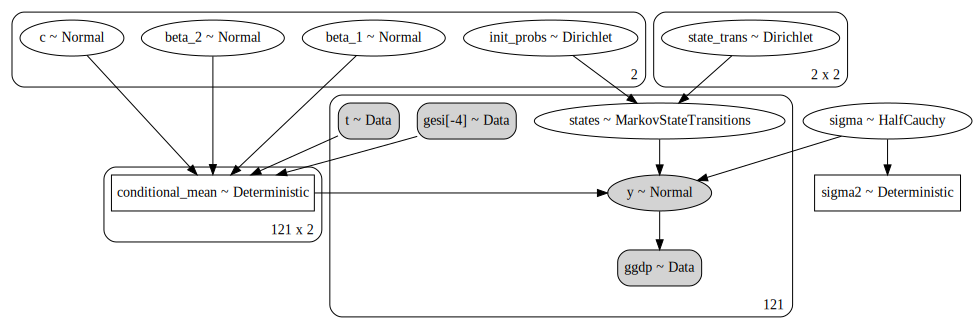

In [85]:
gvm = pm.model_to_graphviz(m)
gvm
gvm

## Fit

In [95]:
with m:
    trace = pm.sample(draws=2000, tune=4000, chains=8, cores=2)

Multiprocess sampling (8 chains in 2 jobs)
CompoundStep
>NUTS: [state_trans, init_probs, sigma, beta_2, beta_1, c]
>BinaryGibbsMetropolis: [states]
Sampling 8 chains, 229 divergences: 100%|██████████| 48000/48000 [40:24<00:00, 19.79draws/s]  
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6185554567425414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.991764713400084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9047534245889395, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `

In [96]:
with m:
    ifd = az.from_pymc3(
        trace=trace,
        dims={
            'init_probs': ['STATE'],
            "state_trans": ["STATE", "AUX_STATE"],
            'states': ["OBS"],
            "y": ["OBS"],
            "ggdp": ["OBS"],
            "gesi[-4]": ["OBS"],
            "t": ["OBS"],
            "conditional_mean": ["OBS", "STATE"],
            "c": ["STATE"],
            "beta_1": ["STATE"],
            "beta_2": ["STATE"],
        },
        coords={
            "OBS": np.arange(T),
            "STATE": np.arange(L),
            "AUX_STATE": np.arange(L),
        },
    )

## Check coeffs

In [97]:
ifd.posterior

<xarray.Dataset>
Dimensions:           (AUX_STATE: 2, OBS: 121, STATE: 2, chain: 8, draw: 2000)
Coordinates:
  * chain             (chain) int64 0 1 2 3 4 5 6 7
  * draw              (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * STATE             (STATE) int64 0 1
  * OBS               (OBS) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119 120
  * AUX_STATE         (AUX_STATE) int64 0 1
Data variables:
    beta_1            (chain, draw, STATE) float64 -0.09131 1.527 ... -1.024
    beta_2            (chain, draw, STATE) float64 0.2563 -1.466 ... 4.278
    states            (chain, draw, OBS) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    c                 (chain, draw, STATE) float64 83.54 172.9 ... 90.35 290.9
    sigma             (chain, draw) float64 3.003 3.017 2.942 ... 2.965 3.22
    sigma2            (chain, draw) float64 9.018 9.1 8.655 ... 9.842 8.79 10.37
    init_probs        (chain, draw, STATE) float64 0.4247 0.5753 ... 0.3203
    state_trans       (chain, draw, STATE, AUX_STATE) float64 0.9841 ... 0.3178
    conditional_mean  (chain, draw, OBS, STATE) float64 110.9 16.24 ... 611.3
Attributes:
    created_at:                 2020-06-02T16:32:56.884773
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.8

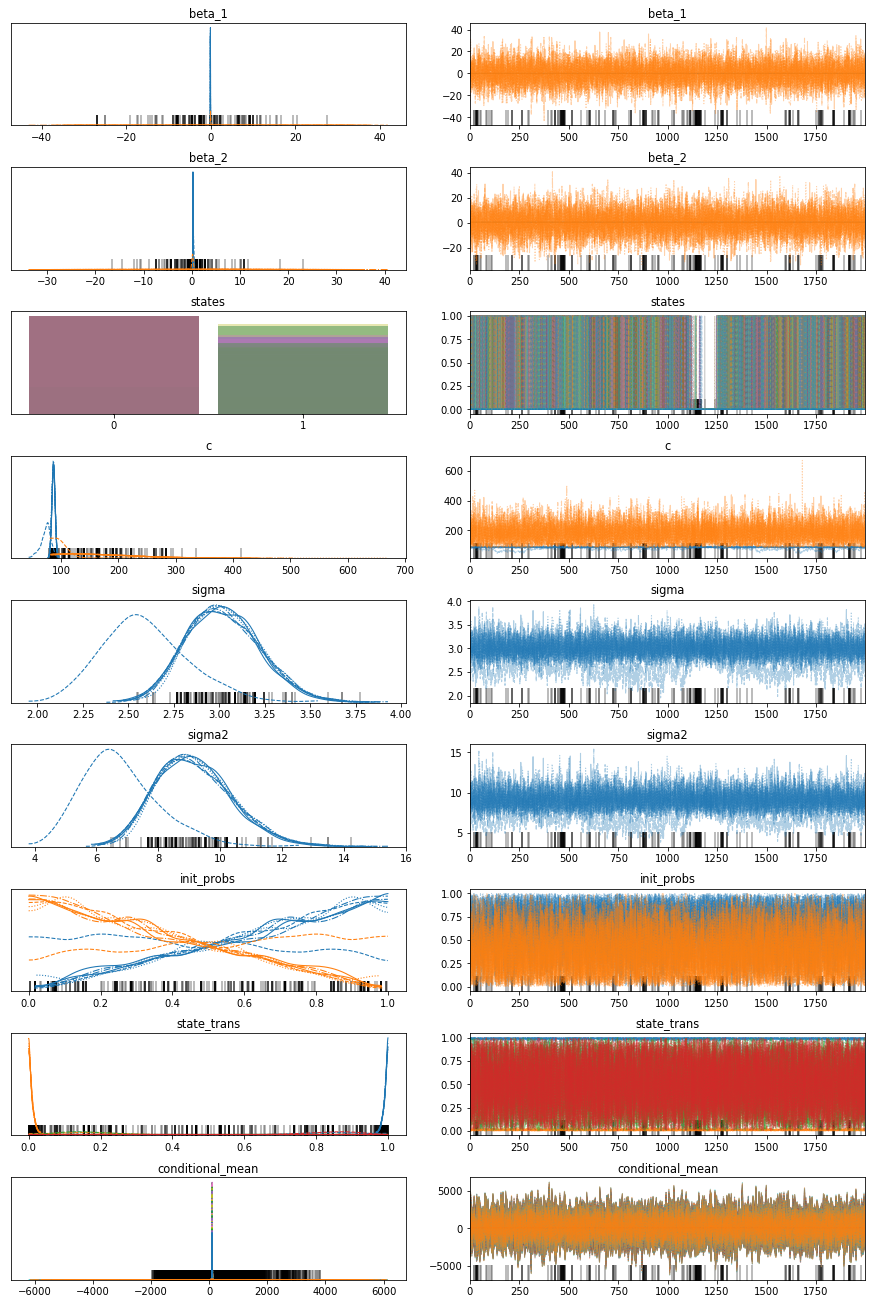

In [98]:
pm.traceplot(ifd);

## Coeff means

In [99]:
post_mean = ifd.posterior.mean(dim=['chain','draw'])

In [100]:
post_mean

<xarray.Dataset>
Dimensions:           (AUX_STATE: 2, OBS: 121, STATE: 2)
Coordinates:
  * STATE             (STATE) int64 0 1
  * OBS               (OBS) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119 120
  * AUX_STATE         (AUX_STATE) int64 0 1
Data variables:
    beta_1            (STATE) float64 -0.09945 -0.0284
    beta_2            (STATE) float64 0.2493 0.05978
    states            (OBS) float64 0.08263 0.06869 0.07006 ... 0.09819 0.09094
    c                 (STATE) float64 84.87 166.1
    sigma             float64 2.969
    sigma2            float64 8.878
    init_probs        (STATE) float64 0.6404 0.3596
    state_trans       (STATE, AUX_STATE) float64 0.9633 0.03667 0.4665 0.5335
    conditional_mean  (OBS, STATE) float64 111.5 172.5 111.3 ... 98.77 168.9

In [101]:
post_mean['state_trans'].values

array([[0.96332907, 0.03667093],
       [0.46646921, 0.53353079]])

In [102]:
pd.concat(
    [
        post_mean['conditional_mean'].to_series().unstack('STATE'),
        post_mean['states'].to_series(),
    ],
    keys=[
        'cond_mean',
        'state',
    ],
    axis='columns'
)

cond_mean                 state
STATE           0           1    states
OBS                                    
0      111.513253  172.474291  0.082625
1      111.297465  172.417997  0.068687
2      110.820709  172.299124  0.070062
3      109.919278  172.078417  0.070625
4      109.215484  171.905101  0.069500
..            ...         ...       ...
116     98.291238  168.775994  0.085875
117     98.888565  168.914680  0.085812
118     99.504683  169.057872  0.095937
119     99.570120  169.069014  0.098187
120     98.774938  168.873785  0.090938

[121 rows x 3 columns]

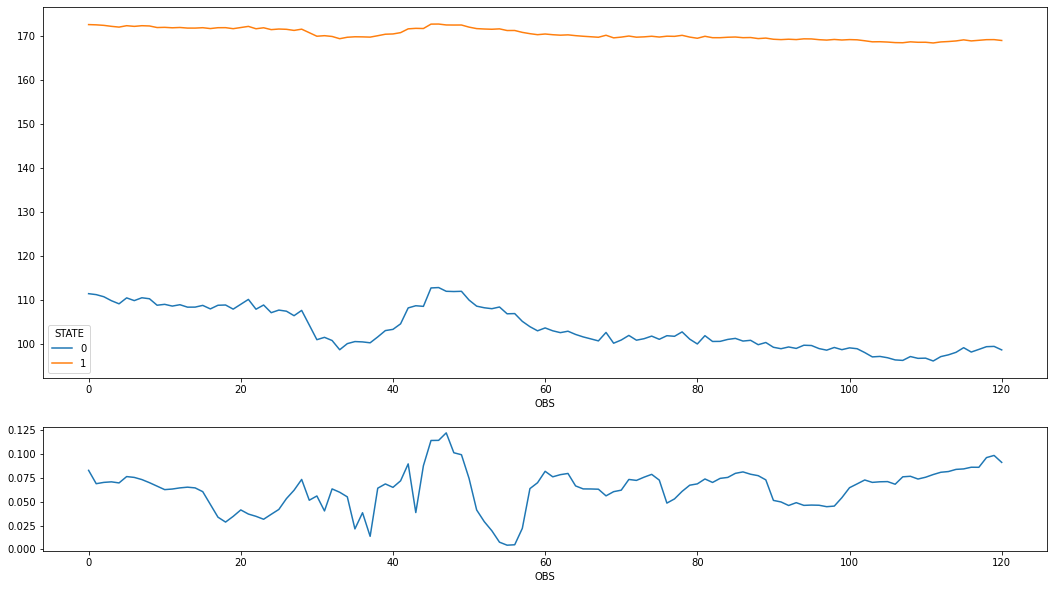

In [103]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={"height_ratios": [3, 1]})

post_mean['conditional_mean'].to_series().unstack('STATE').plot(ax=ax[0])
post_mean['states'].to_series().plot(ax=ax[1])
fig;